In [353]:
# @title Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parser for commit/abort lines in your logs
def parse_log(file_path):
    records = []
    with open(file_path, 'r') as f:
        for line in f:
            if '] commit:' in line:
                parts = line.split()
                time_str = parts[1]  # e.g. '19:58:54.552809'
                commit = int(line.split('commit:')[1].split()[0])
                abort  = int(line.split('abort:')[1].split()[0])
                records.append({'time': time_str, 'commit': commit, 'abort': abort})
    df = pd.DataFrame(records)
    # Convert to datetime and baseline to t=0
    df['time']    = pd.to_datetime(df['time'], format='%H:%M:%S.%f')
    df['seconds'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()
    return df



In [354]:
# results folder
results_folder = 'results/'

# Early Testing

**Intuition:**
- For high contention workloads, we want smaller batch sizes to reduce latency from large batches waiting.
- For low contention, we can increase batch size to maximize utilization of threads and improve throughput.


### Original Baselines
Rather than plotting the throughputs over time, I will simply compare the average throughput over 10 runs.

In [355]:
# function to return the average total commits from a results file (assuming  10 runs)
import re

def average_total_commit(file_path):
    total_commits = []
    pattern = re.compile(r'total commit:\s*([0-9.]+)')

    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                total_commits.append(float(match.group(1)))

    if len(total_commits) != 10:
        raise ValueError(f"Expected 10 total commit entries, but found {len(total_commits)}")

    return sum(total_commits) / 10

In [356]:
average_total_commit(f'{results_folder}before_high_contention.txt')

18797.77

In [357]:
average_total_commit(f'{results_folder}before_low_contention.txt')

17882.18

### initial investigation of manual batch sizes
Using batch_size = 1000 as a baseline, we test batch sizes of 100, 300, 500, 700, 900, and 1100
*NOTE: to run the experiments and output as a text file use:*

./run_10.sh > results.txt 2>&1

In [358]:
# batch size 1900
average_total_commit(f'{results_folder}batch_size_1900_crossratio_100.txt')

31538.379999999997

In [359]:
# batch size 1700
average_total_commit(f'{results_folder}batch_size_1700_crossratio_100.txt')

29604.7

In [360]:
# batch size 1500
average_total_commit(f'{results_folder}batch_size_1500_crossratio_100.txt')

27321.4

In [361]:
# batch size 1300
average_total_commit(f'{results_folder}batch_size_1300_crossratio_100.txt')

25323.870000000003

In [362]:
# batch size 1100
average_total_commit(f'{results_folder}batch_size_1100_crossratio_100.txt')

20240.07

In [363]:
# batch size 900
average_total_commit(f'{results_folder}batch_size_900_crossratio_100.txt')

15800.91

In [364]:
# batch size 700
average_total_commit(f'{results_folder}batch_size_700_crossratio_100.txt')

12745.560000000001

In [365]:
# batch size 500
average_total_commit(f'{results_folder}batch_size_500_crossratio_100.txt')

10926.57

# Testing Parameter Values for Contention
Further investigation showed that high contention isn't just with 100% cross ratio, rather other parameters like zipf and keys should be modified as well

In [366]:
def average_commit_and_abort_rate(file_path):
    """
    Parse an Aria/YCSB log that contains *10* runs and return:
        1) the mean of the 'total commit:' values
        2) the mean abort-rate across runs
           (abort-rate_i = average_abort_i / (average_commit_i + average_abort_i))
    Raises ValueError if it can’t find exactly 10 runs.
    """
    total_commits = []
    abort_rates   = []

    # e.g. "total commit: 29394"
    total_commit_re = re.compile(r'total commit:\s*([0-9.]+)')

    # e.g. "average commit: 29394 abort: 823.5 ..."
    avg_line_re = re.compile(
        r'average commit:\s*([0-9.]+)\s+abort:\s*([0-9.]+)'
    )

    with open(file_path, 'r') as f:
        for line in f:
            m_tot = total_commit_re.search(line)
            if m_tot:
                total_commits.append(float(m_tot.group(1)))
                continue            # total line never also matches avg regex

            m_avg = avg_line_re.search(line)
            if m_avg:
                commit = float(m_avg.group(1))
                abort  = float(m_avg.group(2))
                abort_rate = abort / (commit + abort) if (commit + abort) else 0
                abort_rates.append(abort_rate)

    # sanity-check: expect 10 runs
    if len(total_commits) != 10 or len(abort_rates) != 10:
        raise ValueError(
            f"Expected 10 runs, found {len(total_commits)} total-commit lines "
            f"and {len(abort_rates)} average-commit lines."
        )

    avg_commit      = sum(total_commits) / 10
    avg_abort_rate  = sum(abort_rates)  / 10    # still a fraction, e.g. 0.27

    return avg_commit, avg_abort_rate

In [367]:
# results from command: ./run_10_high_contention.sh > results.txt 2>&1
# --batch_size=1000 --read_write_ratio=60 --cross_ratio=100 --keys=20000 --zipf=0.8 --two_partitions=true
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}contention_test_1.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 5958.4
Average abort rate: 68.69%


In [368]:
# --batch_size=1000 --read_write_ratio=80 --cross_ratio=50 --keys=40000 --zipf=0.65 --two_partitions=true
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}contention_test_2.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 15964.37
Average abort rate: 13.38%


In [369]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}before_high_contention.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 18797.77
Average abort rate: 1.49%


In [370]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}before_low_contention.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 17882.18
Average abort rate: 1.46%


In [371]:
# --batch_size=1000 --read_write_ratio=80 --cross_ratio=100 --keys=40000 --zipf=0.65 --two_partitions=true
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}contention_test_3.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 15616.51
Average abort rate: 13.39%


# Final Contention Ladder
3 levels of contention to test implementations: low, med, high

### Low Contention
--batch_size=1000 --read_write_ratio=80 --cross_ratio=70 --keys=40000 --zipf=0.1 --two_partitions=true

In [372]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}low_contention.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 17994.120000000003
Average abort rate: 1.48%


### Medium Contention
--batch_size=1000 --read_write_ratio=80 --cross_ratio=80 --keys=20000 --zipf=0.6 --barrier_delayed_percent=0 --barrier_artificial_delay_ms=0

In [373]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 15738.85
Average abort rate: 15.68%


### High Contention
--batch_size=1000 --read_write_ratio=80 --cross_ratio=90 --keys=18000 --zipf=0.75 --barrier_delayed_percent=0 --barrier_artificial_delay_ms=0

In [374]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 12356.61
Average abort rate: 35.41%


# testing manual batch size changes w/ new baselines
After deciding on a better contention ladder based on abort rates of around (1.5%, 15%, 35%), we now revisit the manual changing of batch sizes to observe how it affects the throughput at various contention levels.

### function plotting performance for different batch sizes

In [375]:
import matplotlib.pyplot as plt
import os

# Assumes this function is already defined elsewhere
# from your_module import average_commit_and_abort_rate

def plot_commit_and_abort_rates(contention_level, results_folder='./results/', batch_sizes=None):
    """
    Plots side-by-side subplots for average commit and abort rates for a given contention level.

    Parameters:
    - contention_level: str, e.g., "low_contention" or "medium_contention"
    - results_folder: str, path to folder containing result .txt files
    - batch_sizes: list of int, batch sizes to evaluate (default: [500, 1000, 1500, 2000])
    """
    if batch_sizes is None:
        batch_sizes = [500, 1000, 1500, 2000, 2500]

    commit_rates = []
    abort_rates = []
    valid_batch_sizes = []

    for size in batch_sizes:
        log_file = os.path.join(results_folder, f"{contention_level}_{size}.txt")
        try:
            average_commit, avg_abort_rate = average_commit_and_abort_rate(log_file)
            commit_rates.append(average_commit)
            abort_rates.append(avg_abort_rate * 100)  # convert to percent
            valid_batch_sizes.append(size)
            print(f"{contention_level} - Batch size {size}: Commit = {average_commit:.2f}, Abort = {avg_abort_rate:.2%}")
        except FileNotFoundError:
            print(f"Warning: File {log_file} not found. Skipping.")
            continue

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Commit Rate Plot
    ax1.plot(valid_batch_sizes, commit_rates, marker='o', color='blue', label='Commits')
    ax1.set_title(f'Average Throughput\n({contention_level.replace("_", " ").title()})')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Average Throughput (commits/sec)')
    ax1.grid(True)
    # ax1.legend()

    # Abort Rate Plot
    ax2.plot(valid_batch_sizes, abort_rates, marker='x', color='red', label='Abort Rate')
    ax2.set_title(f'Average Abort Rate (%)\n({contention_level.replace("_", " ").title()})')
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Abort Rate (%)')
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_commit_and_abort_rates("low_contention")




## Low Contention (1.5% abort rate)
BASELINE (batch size 1000) - Average commit: 17994.120000000003, Average abort rate: 1.48%

### Raw Numbers

In [376]:
# BATCH SIZE 500
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}low_contention_500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 9495.33
Average abort rate: 0.69%


In [377]:
# BATCH SIZE 1500
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}low_contention_1500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 28800.53
Average abort rate: 2.37%


In [378]:
# BATCH SIZE 2000
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}low_contention_2000.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 33705.0
Average abort rate: 3.33%


In [379]:
# BATCH SIZE 2500
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}low_contention_2500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 39639.1
Average abort rate: 4.38%


### Results Plotted

low_contention - Batch size 500: Commit = 9495.33, Abort = 0.69%
low_contention - Batch size 1000: Commit = 17994.12, Abort = 1.48%
low_contention - Batch size 1500: Commit = 28800.53, Abort = 2.37%
low_contention - Batch size 2000: Commit = 33705.00, Abort = 3.33%
low_contention - Batch size 2500: Commit = 39639.10, Abort = 4.38%


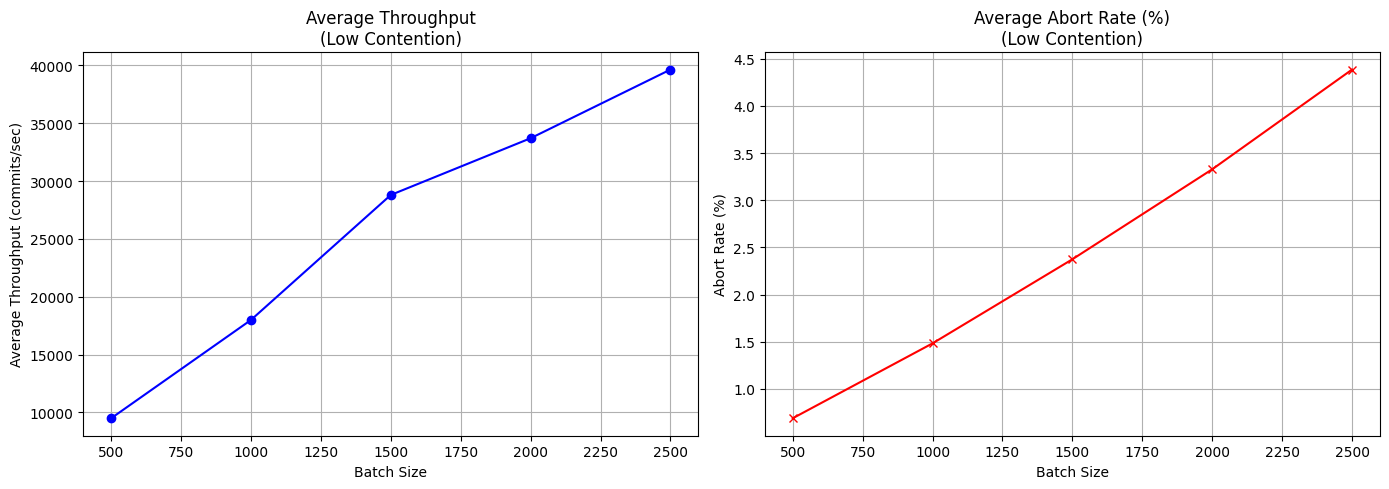

In [380]:
plot_commit_and_abort_rates("low_contention")

## Medium Contention (15% abort rate)

### Raw Numbers

In [381]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention_500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 8278.9
Average abort rate: 8.57%


In [382]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention_1000.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 15738.85
Average abort rate: 15.68%


In [383]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention_1500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 22134.84
Average abort rate: 21.42%


In [384]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention_2000.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 29179.809999999998
Average abort rate: 26.27%


In [385]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}medium_contention_2500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 32853.2
Average abort rate: 30.35%


### Results Plotted

medium_contention - Batch size 500: Commit = 8278.90, Abort = 8.57%
medium_contention - Batch size 1000: Commit = 15738.85, Abort = 15.68%
medium_contention - Batch size 1500: Commit = 22134.84, Abort = 21.42%
medium_contention - Batch size 2000: Commit = 29179.81, Abort = 26.27%
medium_contention - Batch size 2500: Commit = 32853.20, Abort = 30.35%


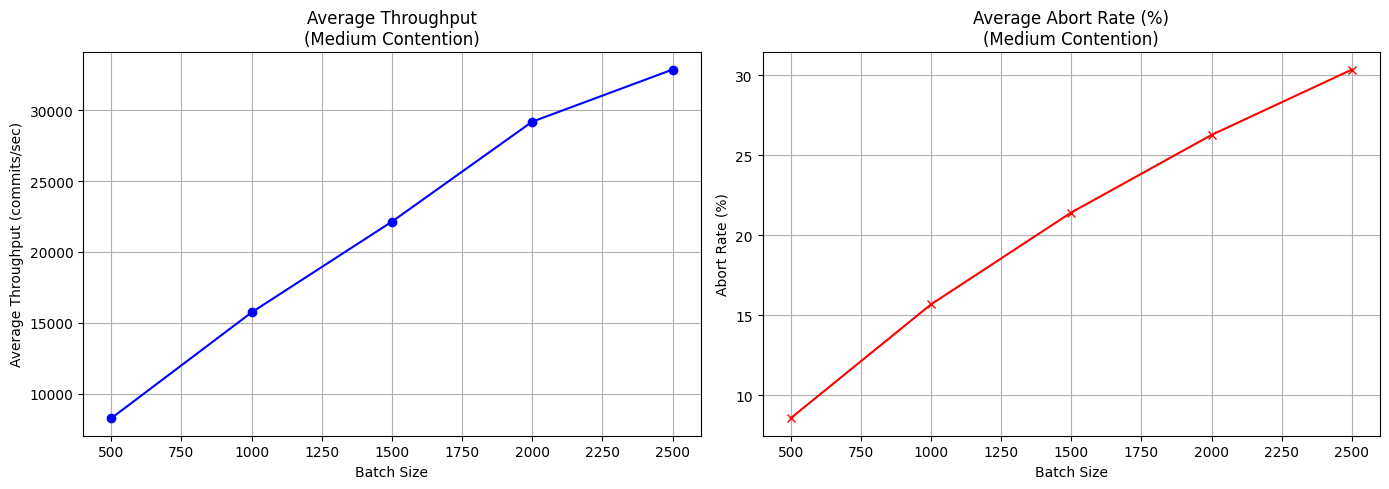

In [386]:
plot_commit_and_abort_rates("medium_contention")

## High Contention (35% abort rate)

### Raw Numbers

In [387]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention_500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 6774.4800000000005
Average abort rate: 25.28%


In [388]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention_1000.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 12356.61
Average abort rate: 35.41%


In [389]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention_1500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 17112.97
Average abort rate: 41.70%


In [390]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention_2000.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 20264.56
Average abort rate: 46.18%


In [391]:
average_commit, avg_abort_rate = average_commit_and_abort_rate(
    f'{results_folder}high_contention_2500.txt'
)
print(f"Average commit: {average_commit}")
print(f"Average abort rate: {avg_abort_rate:.2%}")

Average commit: 23650.84
Average abort rate: 49.66%


### Results Plotted

high_contention - Batch size 500: Commit = 6774.48, Abort = 25.28%
high_contention - Batch size 1000: Commit = 12356.61, Abort = 35.41%
high_contention - Batch size 1500: Commit = 17112.97, Abort = 41.70%
high_contention - Batch size 2000: Commit = 20264.56, Abort = 46.18%
high_contention - Batch size 2500: Commit = 23650.84, Abort = 49.66%
high_contention - Batch size 3000: Commit = 23438.05, Abort = 52.46%
high_contention - Batch size 3500: Commit = 25699.25, Abort = 54.79%
high_contention - Batch size 4000: Commit = 28551.02, Abort = 56.80%
high_contention - Batch size 10000: Commit = 36845.83, Abort = 69.06%
high_contention - Batch size 20000: Commit = 40797.32, Abort = 76.40%
high_contention - Batch size 40000: Commit = 41905.11, Abort = 81.77%


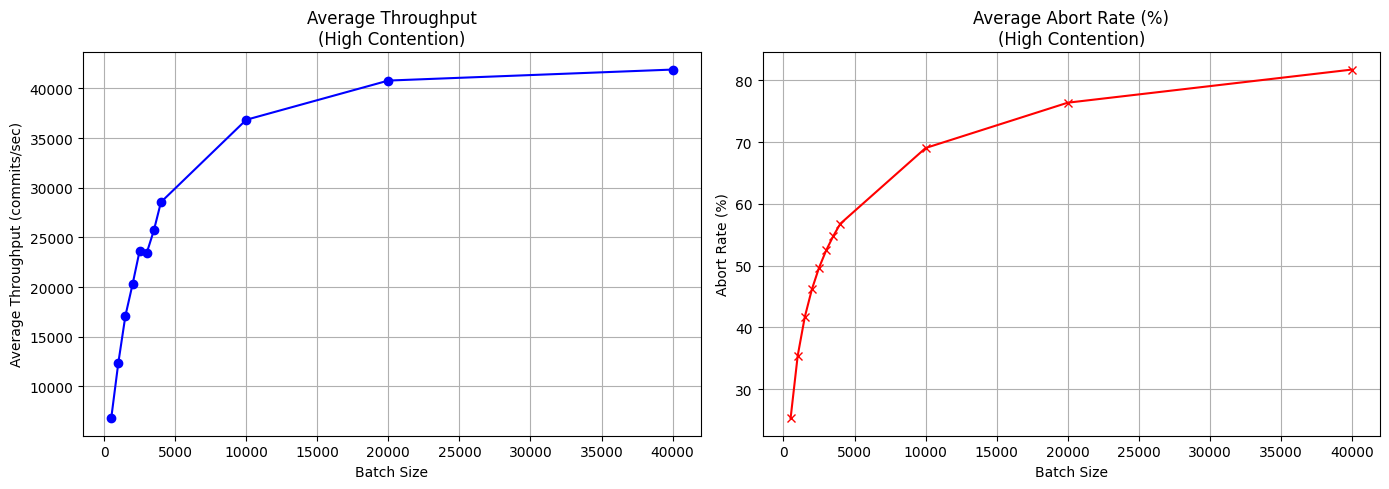

In [392]:
plot_commit_and_abort_rates("high_contention", batch_sizes=[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000, 20000, 40000])

# Investigating Throughput vs. Abort Rate

In [393]:
import matplotlib.pyplot as plt
import os

# Assumes this function is already defined elsewhere
# from your_module import average_commit_and_abort_rate

def plot_throughput_vs_abort_rate(contention_level, results_folder='./results/', batch_sizes=None):
    """
    Plots a scatter plot of throughput (commits/sec) vs. abort rate (%) for a given contention level.

    Parameters:
    - contention_level: str, e.g., "low_contention" or "medium_contention"
    - results_folder: str, path to folder containing result .txt files
    - batch_sizes: list of int, batch sizes to evaluate (default: [500, 1000, 1500, 2000, 2500])
    """
    if batch_sizes is None:
        batch_sizes = [500, 1000, 1500, 2000, 2500]

    commit_rates = []
    abort_rates = []
    labels = []

    for size in batch_sizes:
        log_file = os.path.join(results_folder, f"{contention_level}_{size}.txt")
        try:
            average_commit, avg_abort_rate = average_commit_and_abort_rate(log_file)
            commit_rates.append(average_commit)
            abort_rates.append(avg_abort_rate * 100)  # convert to percent
            labels.append(str(size))  # label points by batch size
            print(f"{contention_level} - Batch size {size}: Commit = {average_commit:.2f}, Abort = {avg_abort_rate:.2%}")
        except FileNotFoundError:
            print(f"Warning: File {log_file} not found. Skipping.")
            continue

    # Plot throughput vs. abort rate
    plt.figure(figsize=(8, 6))
    plt.scatter(abort_rates, commit_rates, color='purple', s=60)

    # Annotate each point with its batch size
    for i, label in enumerate(labels):
        plt.annotate(label, (abort_rates[i], commit_rates[i]), textcoords="offset points", xytext=(5, 5), ha='left')

    plt.title(f'Throughput vs. Abort Rate\n({contention_level.replace("_", " ").title()})')
    plt.xlabel('Abort Rate (%)')
    plt.ylabel('Throughput (commits/sec)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_throughput_vs_abort_rate("low_contention")


high_contention - Batch size 500: Commit = 6774.48, Abort = 25.28%
high_contention - Batch size 1000: Commit = 12356.61, Abort = 35.41%
high_contention - Batch size 1500: Commit = 17112.97, Abort = 41.70%
high_contention - Batch size 2000: Commit = 20264.56, Abort = 46.18%
high_contention - Batch size 2500: Commit = 23650.84, Abort = 49.66%
high_contention - Batch size 3000: Commit = 23438.05, Abort = 52.46%
high_contention - Batch size 3500: Commit = 25699.25, Abort = 54.79%
high_contention - Batch size 4000: Commit = 28551.02, Abort = 56.80%
high_contention - Batch size 10000: Commit = 36845.83, Abort = 69.06%
high_contention - Batch size 20000: Commit = 40797.32, Abort = 76.40%
high_contention - Batch size 40000: Commit = 41905.11, Abort = 81.77%


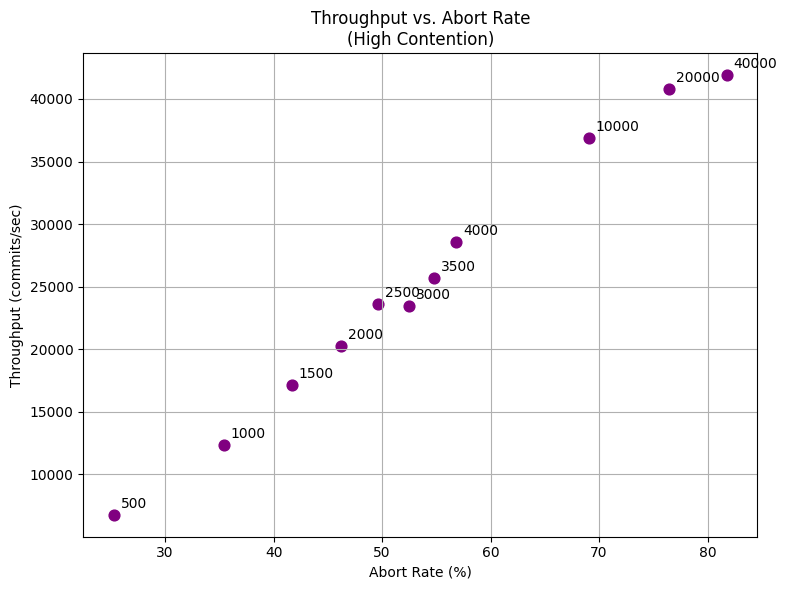

In [394]:
plot_throughput_vs_abort_rate("high_contention", batch_sizes=[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000, 20000, 40000])

# New Baselines (just throughput/abort rate vs. contention for one batch size)

In [395]:
import matplotlib.pyplot as plt
import os

# Assumes this function is already defined elsewhere
# from your_module import average_commit_and_abort_rate

def plot_vs_contention_level(batch_size, results_folder='./results/', contention_levels=None):
    """
    Plots throughput and abort rate vs. contention level for a fixed batch size.

    Parameters:
    - batch_size: int, e.g., 1000
    - results_folder: str, path to folder containing result .txt files
    - contention_levels: list of str, e.g., ['low_contention', 'medium_contention', 'high_contention']
    """
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention']

    throughput = []
    abort_rate = []
    labels = []

    for level in contention_levels:
        filename = f"{level}_{batch_size}.txt"
        filepath = os.path.join(results_folder, filename)
        try:
            average_commit, avg_abort_rate = average_commit_and_abort_rate(filepath)
            throughput.append(average_commit)
            abort_rate.append(avg_abort_rate * 100)  # convert to percent
            labels.append(level.replace('_contention', '').capitalize())  # Clean label for plot
            print(f"{level} - Throughput: {average_commit:.2f}, Abort Rate: {avg_abort_rate:.2%}")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")
            continue

    # Plot: Throughput vs. Contention Level
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(labels, throughput, marker='o', color='blue')
    plt.title(f'Throughput vs. Contention Level\n(Batch Size {batch_size})')
    plt.xlabel('Contention Level')
    plt.ylabel('Throughput (commits/sec)')
    plt.grid(True)

    # Plot: Abort Rate vs. Contention Level
    plt.subplot(1, 2, 2)
    plt.plot(labels, abort_rate, marker='x', color='red')
    plt.title(f'Abort Rate (%) vs. Contention Level\n(Batch Size {batch_size})')
    plt.xlabel('Contention Level')
    plt.ylabel('Abort Rate (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_vs_contention_level(batch_size=1000)


low_contention - Throughput: 17994.12, Abort Rate: 1.48%
medium_contention - Throughput: 15738.85, Abort Rate: 15.68%
high_contention - Throughput: 12356.61, Abort Rate: 35.41%
extreme_contention - Throughput: 6782.87, Abort Rate: 65.25%


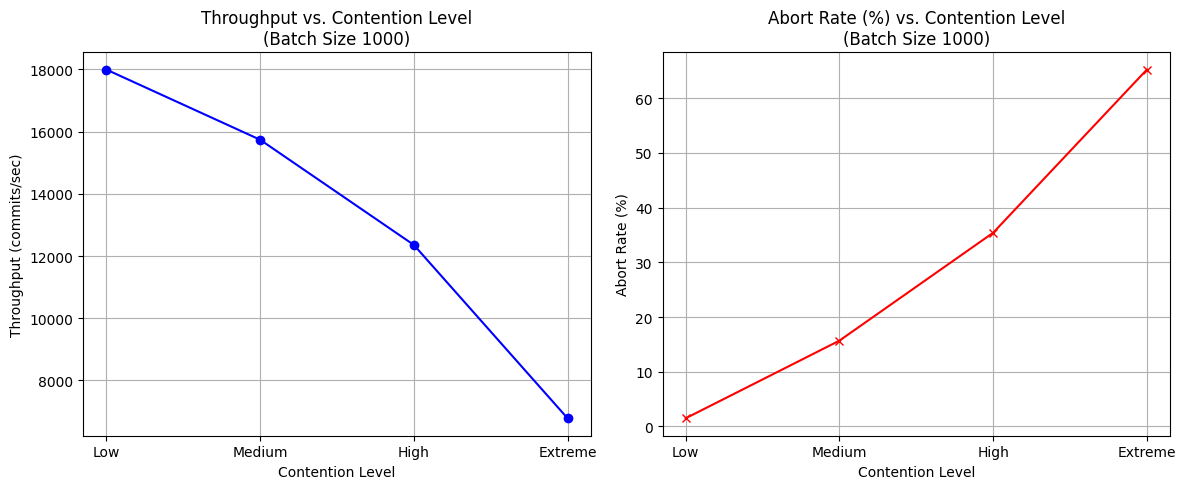

In [396]:
plot_vs_contention_level(batch_size=1000, contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])
